# PCA and RF Classification Analysis of Pooled Dataset
### UPDATED May 13, 2024

In [1]:
# dependences:
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import permutation_importance
from sklearn import tree
from sklearn import preprocessing

import pydotplus
from IPython.display import Image
import mpl_axes_aligner

from sklearn.impute import SimpleImputer

**Load data and process for analysis**

In [2]:
diagnoses = ['ASD', 'AD', 'PD', 'MS']

# color map used for all analyses
color_map = {'AD': '#666666',
             'ASD':'#F0027F',
             'MS': '#FDC086',
             'PD': '#7FC97F'}

# load in data:
df = pd.read_csv('../Data/20440_cleaned_data.csv')

# drop any genus that is not present in one of the diagnoses.
for diag in diagnoses:
    for feature in df.columns:
        drop = 0
        for val in df[feature].loc[df['Diagnosis'] == diag]:
            if val != 0:
                drop +=1
        if drop == 0:
            df = df.drop([feature], axis=1)

# For dropping diagnosis column so we can feed data in:
data = df.drop(['Diagnosis'], axis=1) # data without diagnosis column
data = data.drop(['Unknown'], axis=1) # no unknowns

# make a list of diagnoses:
diagnosis = df["Diagnosis"]

**Standardization**

In [3]:
# standardize within genus:
data_copy = data
columns = data_copy.columns
scaler = preprocessing.StandardScaler().fit(data_copy)
data = pd.DataFrame(scaler.transform(data_copy), columns=columns)

**Show data to check correct:**

In [4]:
data

,Alistipes,Bacteroides,Bifidobacterium,Butyricicoccus,Clostridium,Dorea,Eggerthella,Faecalibacterium,Prevotella,Ruminococcus,...,Roseburia,Rothia,Odoribacter,Lactobacillus,Collinsella,Actinomyces,Coprobacillus,Parabacteroides,Anaerotruncus,Butyrivibrio
0,-0.279743,-0.274721,-0.494535,2.908757,-0.264010,-0.310020,0.715602,-0.282054,6.107520,0.377310,...,-0.792429,-0.153732,-0.503688,-0.097709,-0.404439,-0.243768,-0.226683,-0.528405,-0.288621,-0.168856
1,-0.271075,-0.240027,-0.364661,2.347088,2.647833,-0.364756,-0.422635,-0.423088,-0.254259,0.454707,...,2.073094,-0.153732,-0.503688,-0.097709,-0.404439,-0.243768,-0.226683,-0.528405,-0.288621,-0.168856
2,-0.567960,2.190950,-0.499382,1.865787,1.668238,-0.240674,-0.422635,-0.603423,-0.254259,0.263981,...,0.815632,0.519957,-0.503688,-0.097709,-0.404439,-0.243768,-0.226683,-0.528405,-0.288621,-0.168856
3,-0.427820,0.098596,-0.509312,2.718895,0.581342,0.179933,0.412660,1.490248,1.805702,-0.195309,...,-0.792429,-0.153732,0.295397,-0.097709,-0.404439,-0.243768,-0.226683,-0.528405,-0.288621,-0.168856
4,-0.492406,1.609645,-0.283909,1.191105,1.091819,0.427007,-0.422635,-0.479528,-0.254259,0.033547,...,0.240791,-0.153732,-0.503688,-0.097709,-0.404439,-0.243768,-0.226683,-0.528405,-0.288621,-0.168856
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,-0.567960,-0.872361,-0.468789,-0.405468,-0.397515,0.337731,0.131916,0.414920,-0.254259,-0.495973,...,0.772182,-0.153732,-0.503688,-0.060687,-0.404439,0.475195,-0.226683,-0.528405,-0.288621,-0.168856
389,-0.567960,-0.868283,0.520033,-0.405468,0.613997,-0.417634,0.956084,-0.719067,-0.254259,-0.253432,...,-0.702725,-0.153732,-0.503688,0.036309,6.721598,-0.243768,1.179211,-0.528405,-0.226917,-0.168856
390,-0.567960,-0.856151,-0.548851,-0.405468,-0.529913,-0.503255,0.289941,-0.293625,-0.254259,-0.522148,...,-0.695102,-0.153732,-0.503688,-0.075462,-0.025065,0.294220,0.021187,-0.528405,-0.288621,-0.168856
391,-0.567960,-0.850705,-0.319388,-0.405468,0.443873,1.430648,6.665385,-0.621448,-0.254259,-0.727475,...,-0.617740,-0.153732,-0.503688,-0.012787,-0.404439,-0.243768,15.460568,-0.528405,-0.288621,-0.168856


## PCA of pooled dataset

**Now we perform PCA:**

In [5]:
# prep PCA output dataframe:
columns_list = []

**Run PCA:**

In [6]:
pca = PCA(n_components=.95)
out = pca.fit_transform(data)
for i in range(len(out[0])):
    columns_list.append("PC" + str(i + 1)) # store all PCs

#create df for output of PCA
out_df = pd.DataFrame(out, columns=columns_list)
loadings_pool = pd.DataFrame(pca.components_, columns=data.columns, index=out_df.columns) #collect all loadings

**Visualize variance ratio explained by each component:**

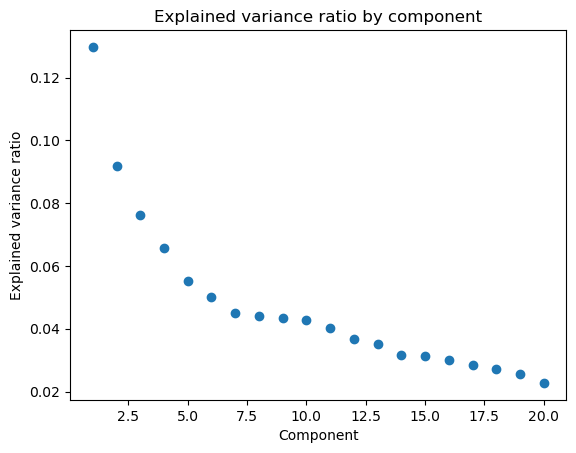

In [7]:
pc = np.linspace(1, len(columns_list), len(columns_list))
var_ratio = pca.explained_variance_ratio_
plt.scatter(pc, var_ratio)
plt.title('Explained variance ratio by component')
plt.xlabel('Component')
plt.ylabel('Explained variance ratio');

**Plot the loadings of the first two principal components**

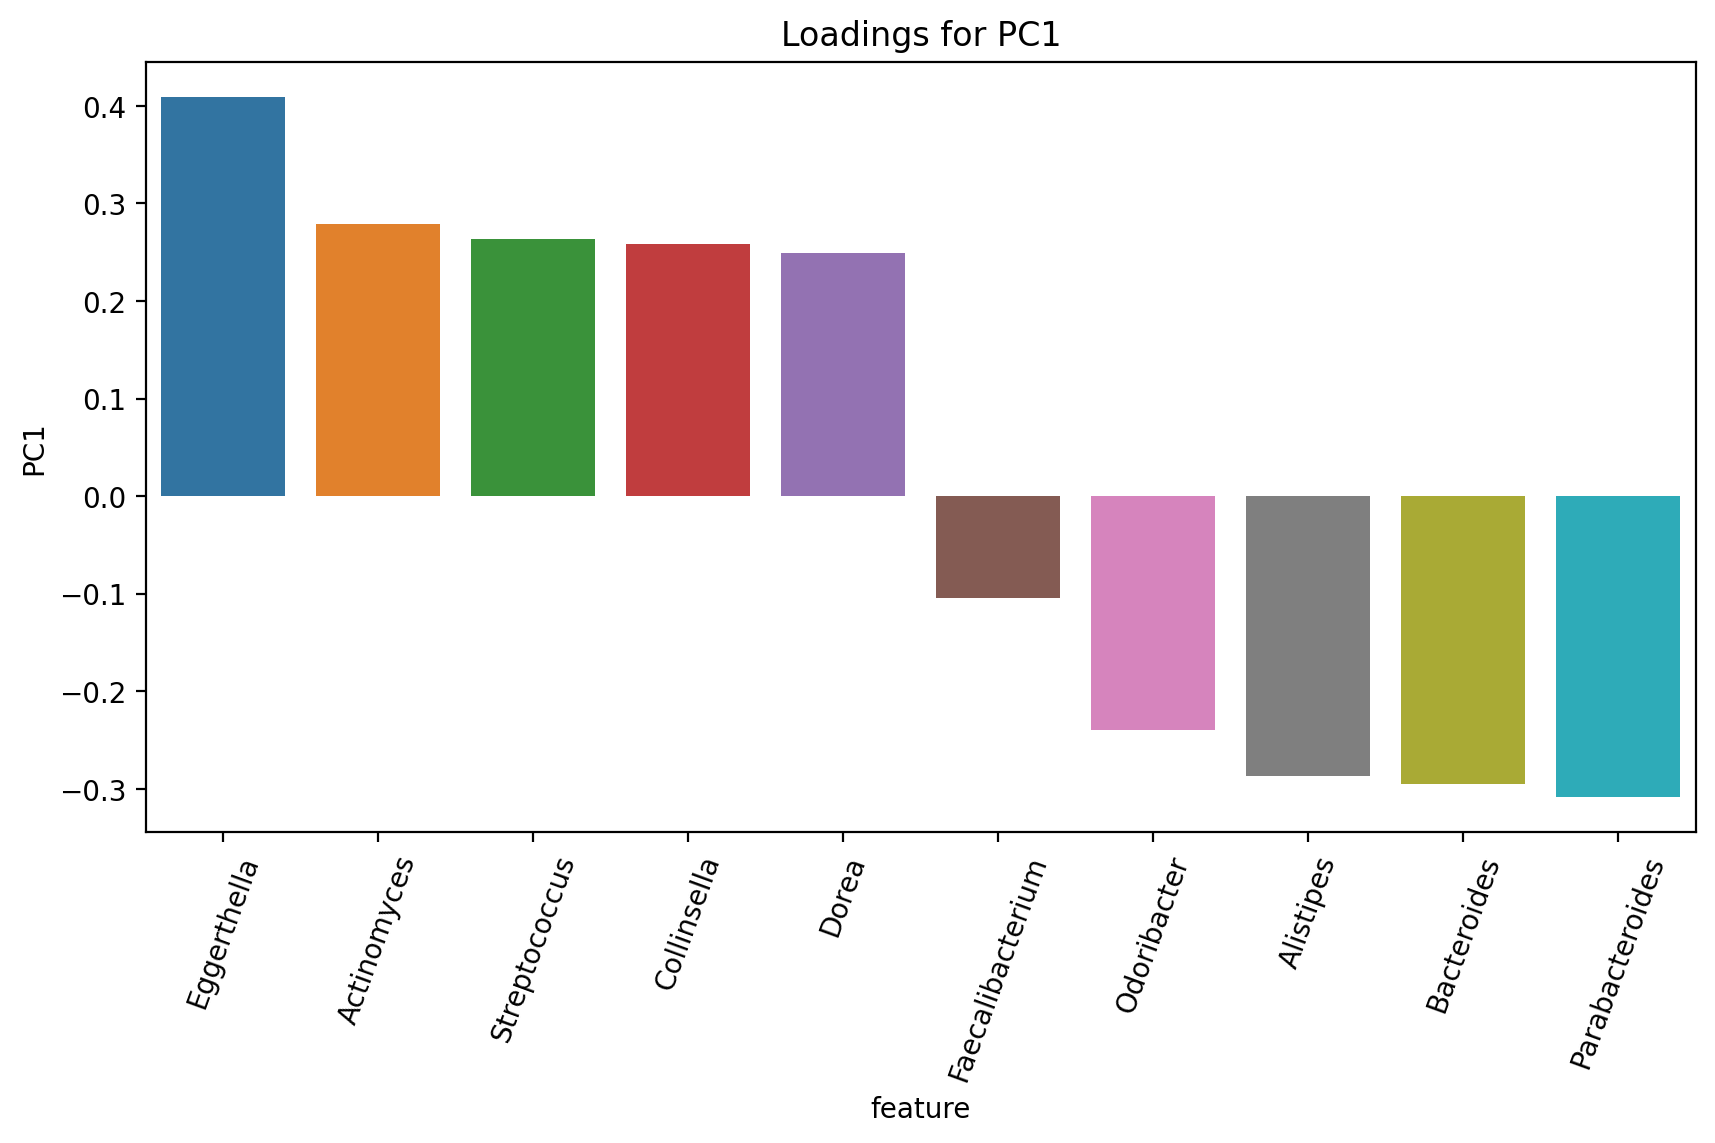

In [8]:
pcs = pca.components_

# create a dataframe with the load of the features in PC1:
load = pd.DataFrame(np.transpose(pcs), columns=['PC'+str(i+1) for i in range(len(columns_list))])
load["feature"] = list(data.columns)

# descending values
load1 = load.sort_values('PC1', ascending=False)
load1_feat = pd.DataFrame(load1[["feature", 'PC1']], columns=['feature', 'PC1']) # for reference

# only keep the big contributors
load1_out = pd.concat([load1_feat[:5], load1_feat[-5:]], ignore_index=True)

# plot
plt.figure(dpi=200, figsize=(10,5))
sns.barplot(load1_out, x='feature', y='PC1')
plt.xticks(rotation=70);
plt.title("Loadings for PC1");
plt.savefig('../Figures/PCA_loadings_PC1_pooled.svg', bbox_inches = "tight")

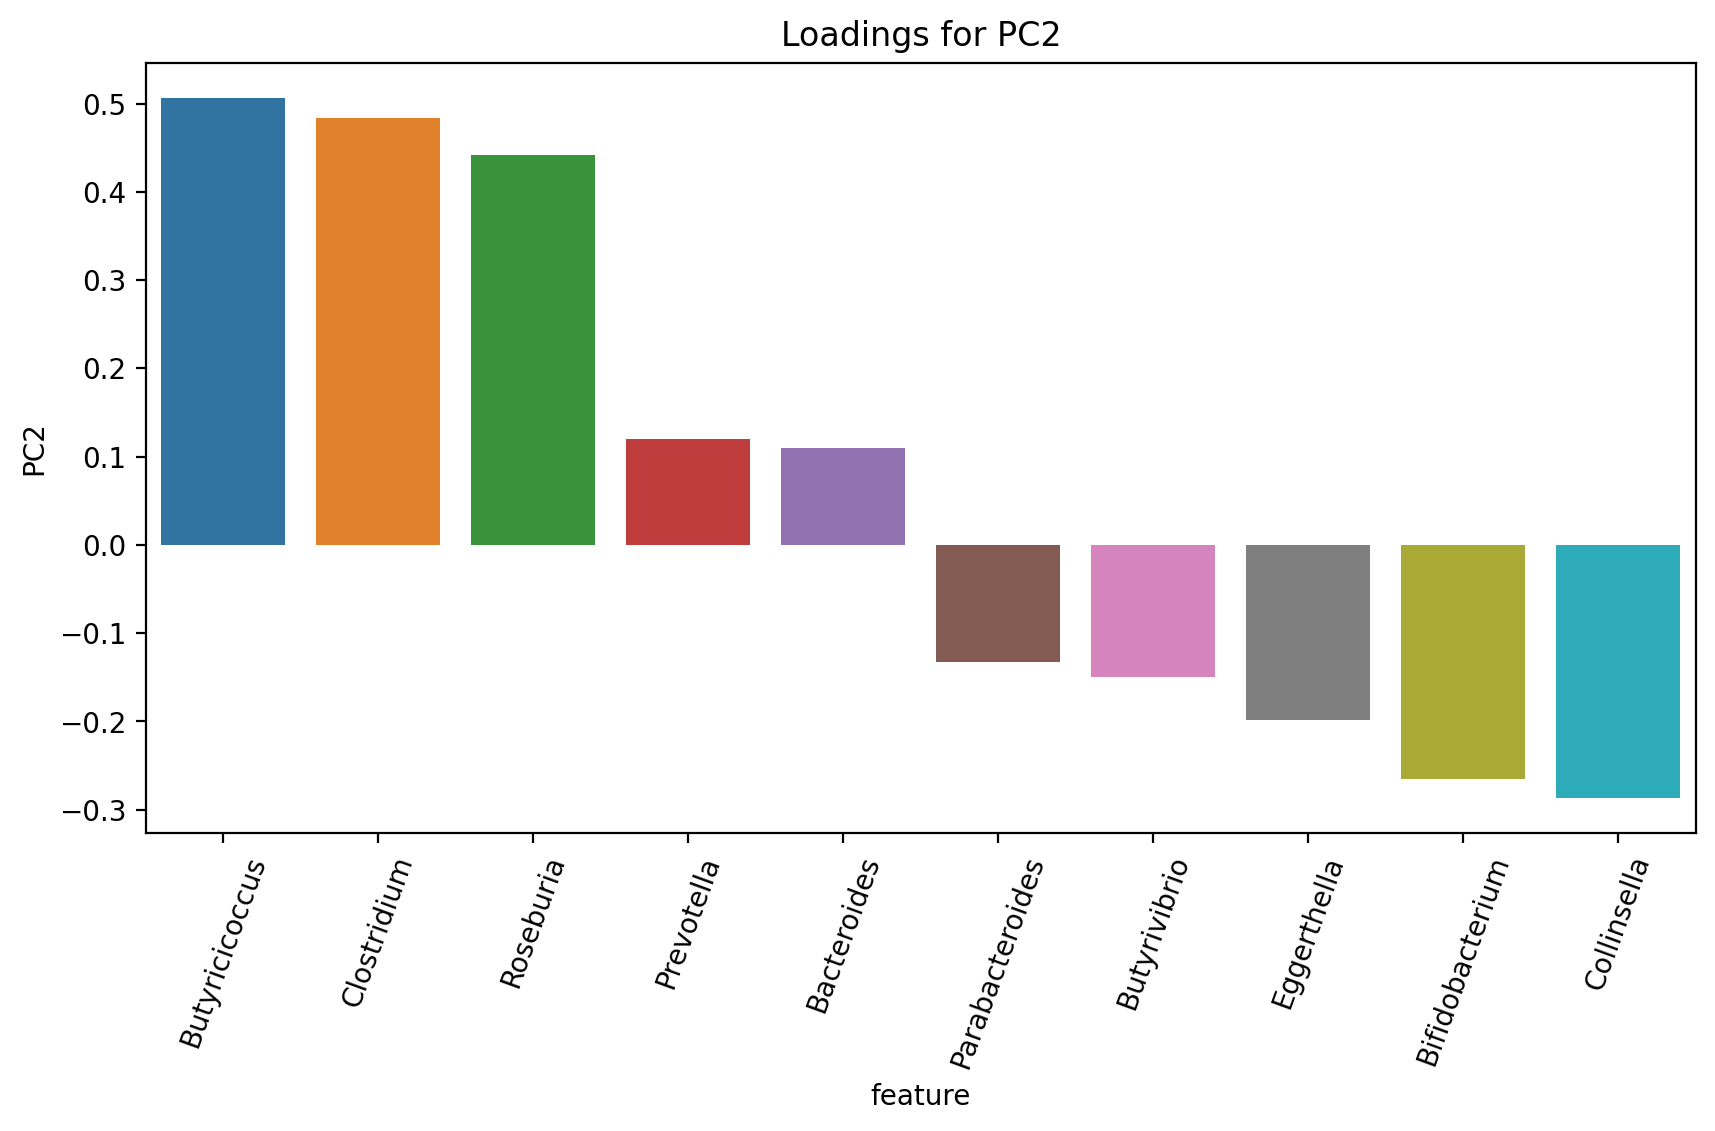

In [9]:
pcs = pca.components_
# create a dataframe with the load of the features in PC2:
load2 = pd.DataFrame(np.transpose(pcs), columns=['PC'+str(i+1) for i in range(len(columns_list))])
load2["feature"] = list(data.columns)

# descending values
load2 = load.sort_values('PC2', ascending=False)
load2_feat = pd.DataFrame(load2[["feature", 'PC2']], columns=['feature', 'PC2']) # for reference

# only keep the big contributors
load2_out = pd.concat([load2_feat[:5], load2_feat[-5:]], ignore_index=True)

# plot
plt.figure(dpi=200, figsize=(10,5))
sns.barplot(load2_out, x='feature', y='PC2')
plt.xticks(rotation=70);
plt.title("Loadings for PC2");
plt.savefig('../Figures/PCA_loadings_PC2_pooled.svg', bbox_inches = "tight")

**Visualize clustering by diagnosis with first two PCs:**

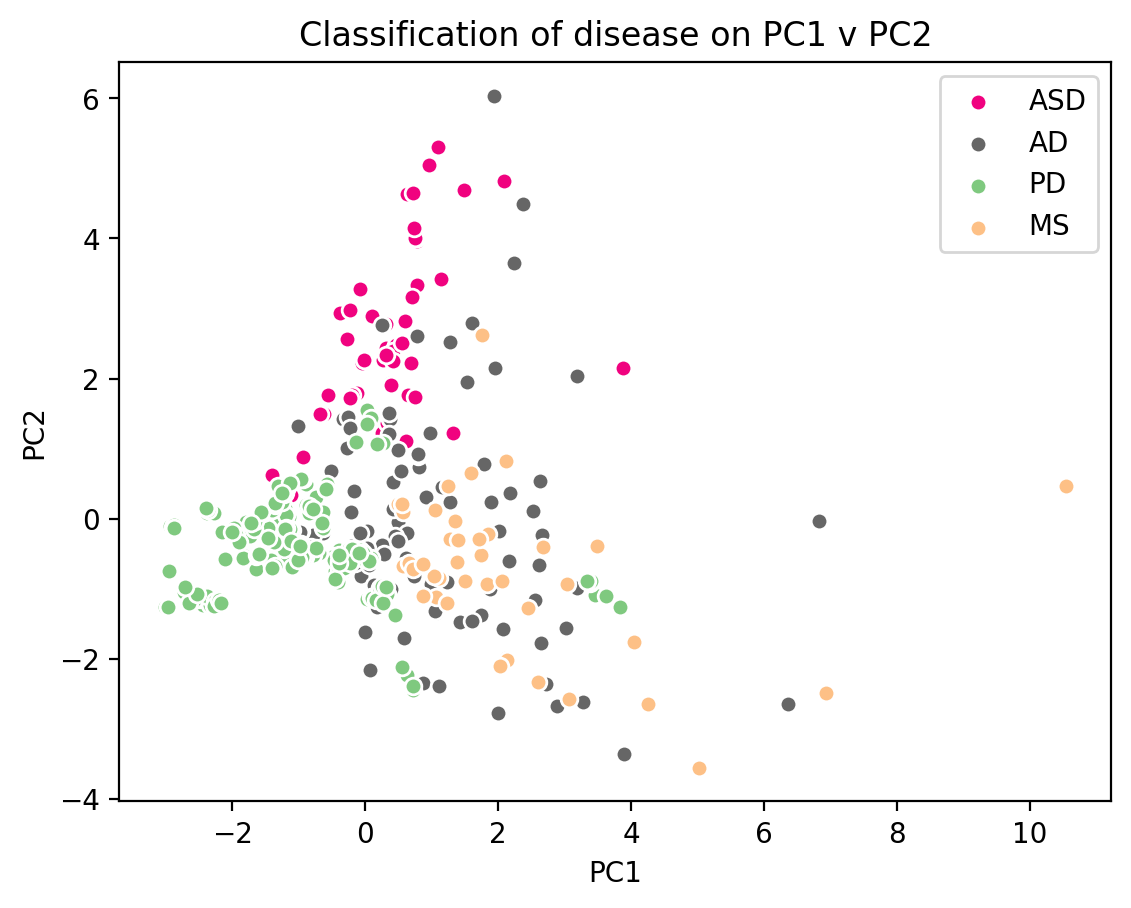

In [10]:
pcs = pca.components_

# set up lists of diagnosis indices:
ASD = []
AD = []
PD = []
Epilepsy = []
MS = []

diagnosis = list(diagnosis)

# indicate which sample indices are which disease:
for i in range(len(diagnosis)):
    if diagnosis[i]=='ASD':
        ASD.append(i)
    if diagnosis[i]=='AD':
        AD.append(i)
    if diagnosis[i]=='PD':
        PD.append(i)
    if diagnosis[i]=='MS':
        MS.append(i)

# plot PC1 v PC2, indicating which indices of these are which disease:
plt.figure(dpi=200)

plt.scatter(out_df['PC1'][ASD], out_df['PC2'][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(out_df['PC1'][AD], out_df['PC2'][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(out_df['PC1'][PD], out_df['PC2'][PD], label='PD', color = color_map['PD'], edgecolor='white')
plt.scatter(out_df['PC1'][MS], out_df['PC2'][MS], label='MS', color = color_map['MS'],edgecolor='white')

plt.legend();
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.title("Classification of disease on PC1 v PC2");
plt.savefig('../Figures/PCA_plot_pooled.svg')

## Biplot creation

**Define biplot function**

In [11]:
def biplot(dfScores, dfLoadings, ax):
    ''' directly sourced from https://insidelearningmachines.com/biplot/ . 
    Altered to only show first four loadings (that contribute most to variance), 
    most negative and most positive from PC1 and PC2'''
    
    #make a scores plot

    #set x-axis label
    ax.set_xlabel("PC1",fontsize=10)
    #set y-axis label
    ax.set_ylabel("PC2",fontsize=10)
    
    #create a second set of axes
    ax2 = ax.twinx().twiny()
    
    #setup font dictionary
    font = {'color':  'black',
            'weight': 'bold',
            'size': 12,
            }
    
    # sort the loadings plot:
    dfLoadings = dfLoadings.sort_values('PC1', axis=1, ascending=False)
    dfLoadings1 = dfLoadings.sort_values('PC2', axis=1, ascending=False)

    # color in lines by PC and orient the labels
    b = 0
    v_orient = ["top", "top", "top", "bottom"]
    h_orient = ["left", "right", "right", "right"]
    col_pc = ["red", "red", "blue", "blue"]

    list_show = [dfLoadings.columns.values[0], dfLoadings.columns.values[-1], dfLoadings1.columns.values[0], dfLoadings1.columns.values[-1]]
    
    #make a loadings plot
    
    for col in list_show:    
        #where do our loading vectors end?
        tipx = dfLoadings.loc['PC1',col]
        tipy = dfLoadings.loc['PC2',col]
        #draw the vector, and write label text for col
        ax2.arrow(0, 0, tipx, tipy, color = col_pc[b], alpha = 0.5)
        ax2.text(tipx*1.05, tipy*1.05, col, fontdict = font, ha = h_orient[b], va = v_orient[b])
        b +=1

    ax2.set_xlim(-.75, .75)
    ax2.set_ylim(-.75, .75)
    #align x = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.xaxes(ax, 0, ax2, 0, 0.5)
    #align y = 0 of ax and ax2 with the center of figure
    mpl_axes_aligner.align.yaxes(ax, 0, ax2, 0, 0.5)

<Figure size 2560x1920 with 0 Axes>

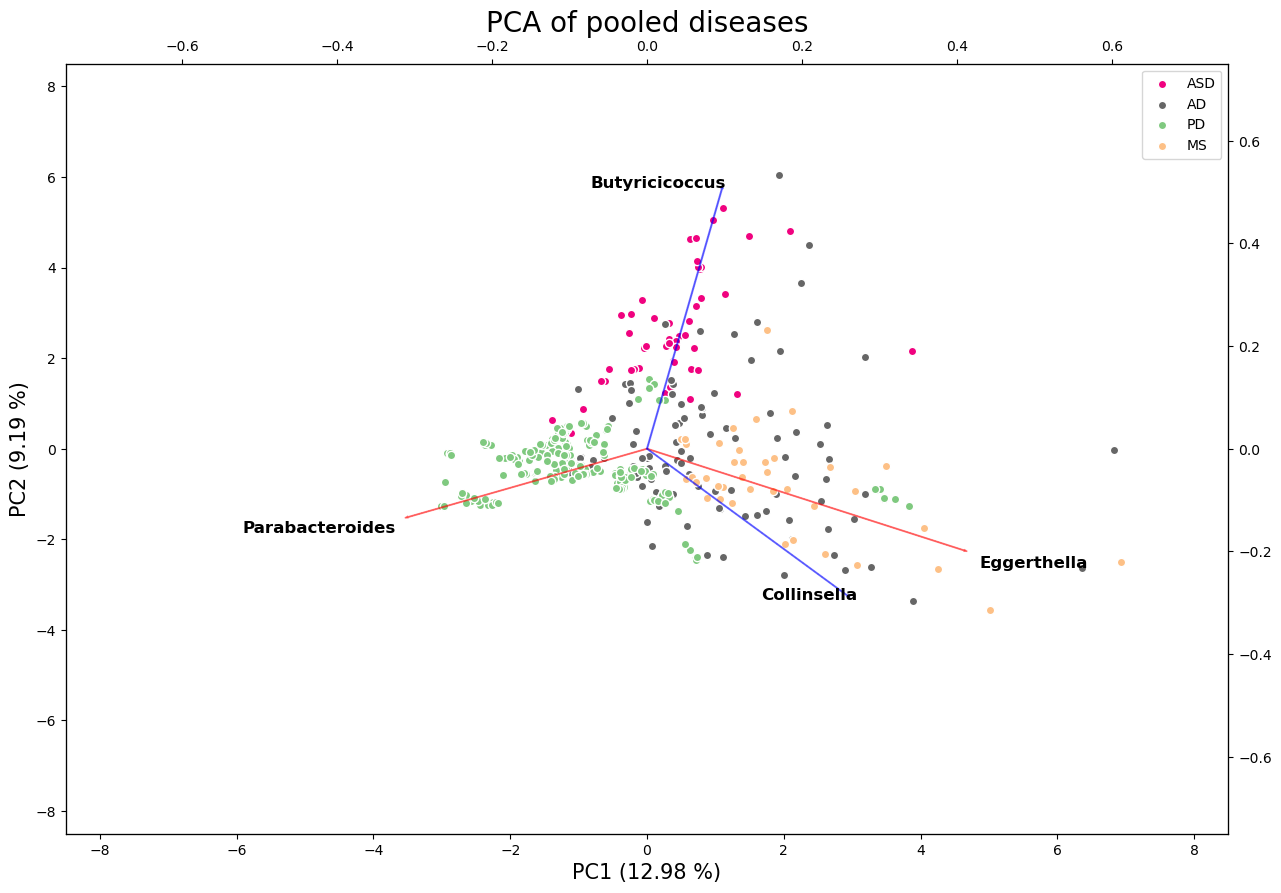

In [12]:
pcs = pca.components_

# set up lists of diagnosis indices:
ASD = []
AD = []
PD = []
Epilepsy = []
MS = []

diagnosis = list(diagnosis)

# indicate which sample indices are which disease:
for i in range(len(diagnosis)):
    if diagnosis[i]=='ASD':
        ASD.append(i)
    if diagnosis[i]=='AD':
        AD.append(i)
    if diagnosis[i]=='PD':
        PD.append(i)
    if diagnosis[i]=='MS':
        MS.append(i)

# plot PC1 v PC2, indicating which indices of these are which disease:
plt.figure(dpi=400)
fig, ax = plt.subplots(1, 1, figsize=(15,10))

ax.scatter(out_df['PC1'][ASD], out_df['PC2'][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
ax.scatter(out_df['PC1'][AD], out_df['PC2'][AD], label='AD', color = color_map['AD'], edgecolor='white')
ax.scatter(out_df['PC1'][PD], out_df['PC2'][PD], label='PD', color = color_map['PD'], edgecolor='white')
ax.scatter(out_df['PC1'][MS], out_df['PC2'][MS], label='MS', color = color_map['MS'],edgecolor='white')

biplot(out_df, loadings_pool, ax)

ax.legend();
ax.set_xlabel("PC1 ({:.2f} %)".format(var_ratio[0] * 100), fontsize=15)
ax.set_ylabel("PC2 ({:.2f} %)".format(var_ratio[1] * 100), fontsize=15)
ax.set_xlim(-8.5,8.5)
ax.set_ylim(-8.5,8.5)
ax.set_title("PCA of pooled diseases", fontsize=20);

plt.savefig('../Figures/PCA_biplot_pooled.svg')

## RF Classifier

In [13]:
# set up classifier
rf = RandomForestClassifier(n_estimators=100) # 100 trees in the forest.
# 100 trees means 100 sub-samples of data

# make training and testing sets:
feat_train, feat_test, diag_train, diag_test = sk.model_selection.train_test_split(data, diagnosis, test_size=0.70)
# chose a test size of 70%

# train:
out = rf.fit(feat_train, diag_train)
# also run a permutation test:
perm_importance = permutation_importance(rf, feat_test, diag_test, n_repeats=100)

# test:
diag_predict = rf.predict(feat_test)

**Accuracy of classifier**

In [14]:
# use built-in accuracy score 
acc = sk.metrics.accuracy_score(diag_test, diag_predict)
print("accuracy of the classifier: {}".format(acc))

accuracy of the classifier: 0.8768115942028986


**Importances plot**

In [15]:
feat = data.columns

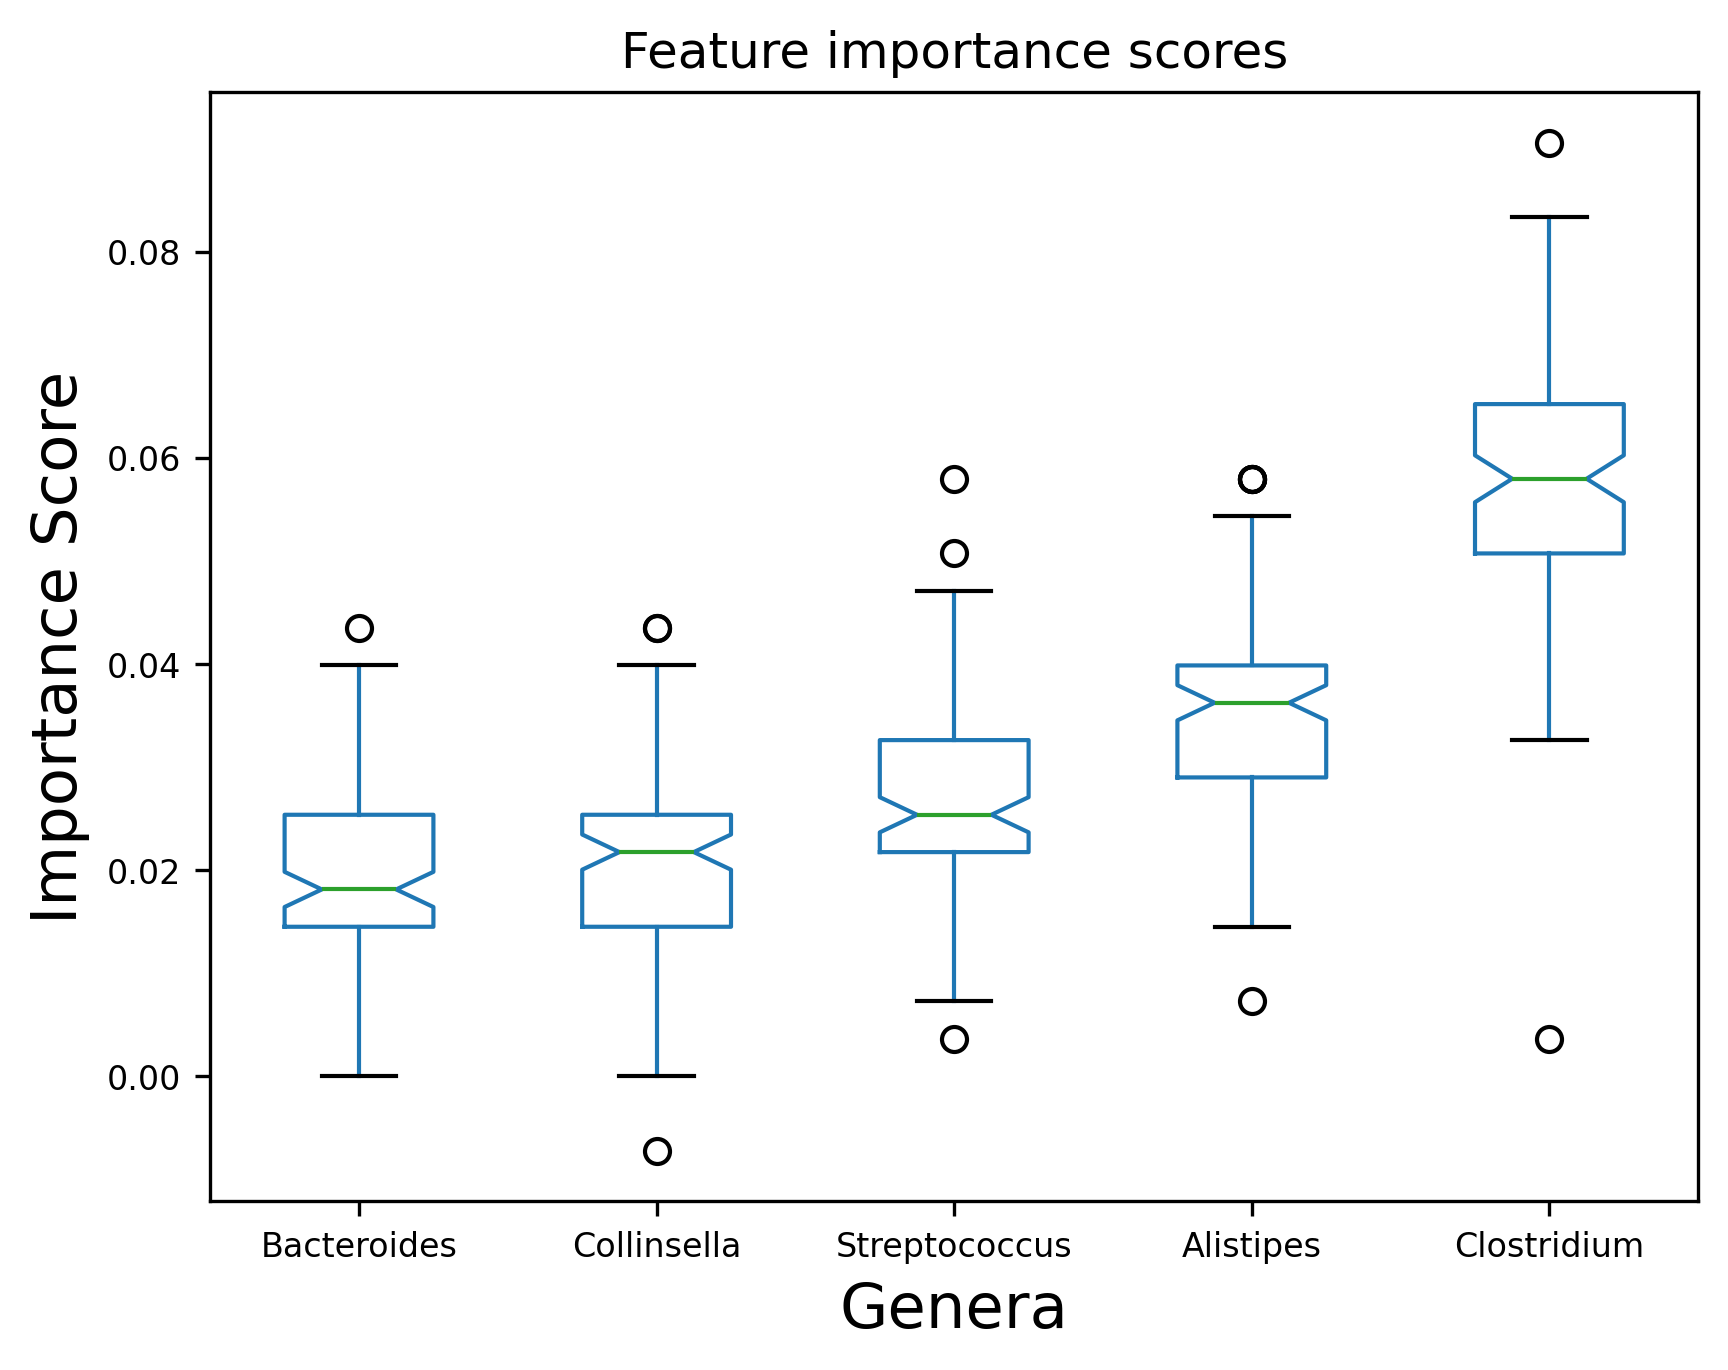

In [16]:
# get the importances from permutation testing:
sorted_id = perm_importance.importances_mean.argsort()
imp_data=pd.DataFrame(perm_importance.importances[sorted_id].transpose(), columns=data.columns[sorted_id])

# plot using a boxplot:
plt.figure(dpi = 300)
imp_data.boxplot(list(imp_data.columns[-5:]), grid=False, meanline=True, fontsize=8, notch=True)
plt.xlabel(xlabel="Genera", fontsize=15)
plt.ylabel(ylabel="Importance Score", fontsize=15)
plt.title("Feature importance scores");
plt.savefig('../Figures/RF_importance_pooled.svg')

**Save importance scores**

In [17]:
# find importance of each feature:
feat_importance = rf.feature_importances_

# make and print table of ranked features by importance:
imp_table = pd.DataFrame(feat, columns=['features'])
imp_table['importance'] = feat_importance
imp_table_sort = imp_table.sort_values('importance', ascending=False)
imp_table_sort = imp_table_sort.round(3)
feat_sort = list(imp_table_sort['features']) # use this for plotting and storing the features
imp_table_sort.head()

,features,importance
4,Clostridium,0.212
0,Alistipes,0.137
1,Bacteroides,0.091
7,Faecalibacterium,0.074
3,Butyricicoccus,0.073


**XY scatter of important features**

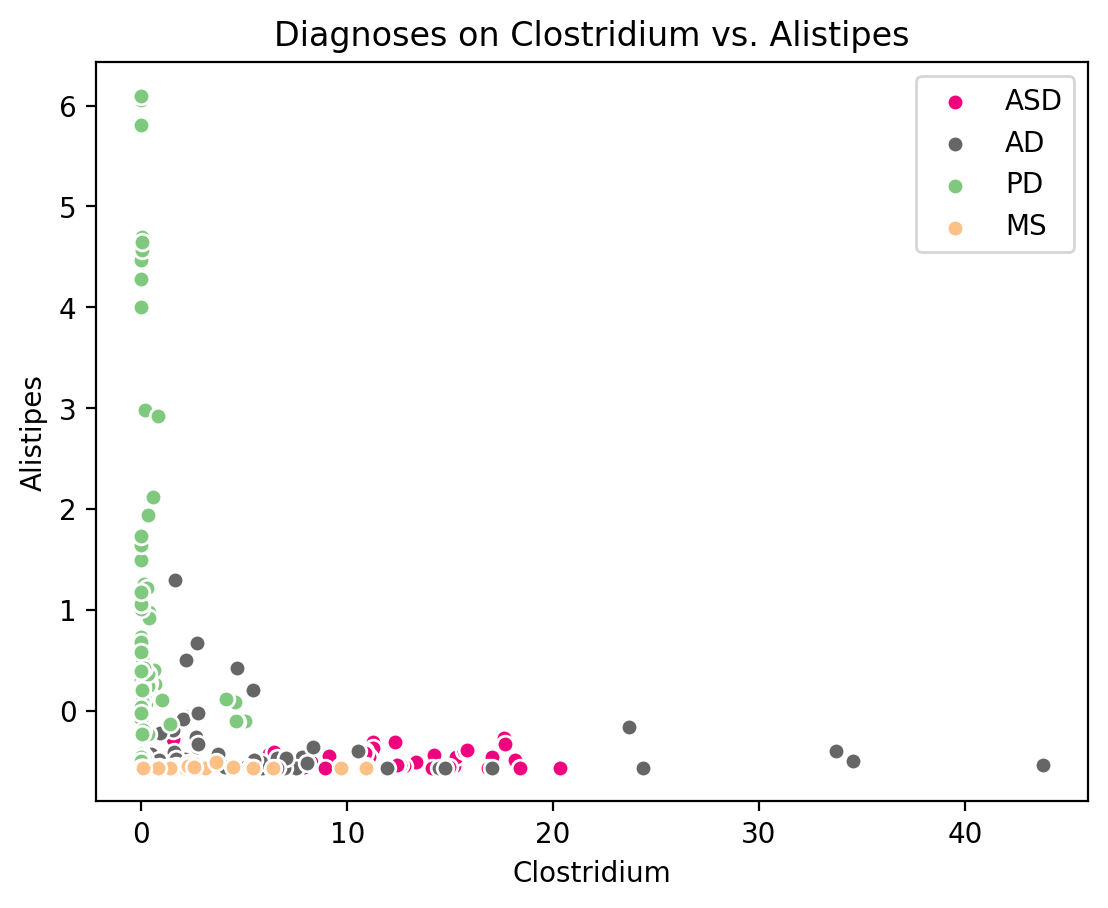

In [18]:
# use the top two most important features from the table of ranked importances
plt.figure(dpi=200)
plt.scatter(df[feat_sort[0]][ASD], data[feat_sort[1]][ASD], label='ASD', color = color_map['ASD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][AD], data[feat_sort[1]][AD], label='AD', color = color_map['AD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][PD], data[feat_sort[1]][PD], label='PD', color = color_map['PD'], edgecolor='white')
plt.scatter(df[feat_sort[0]][MS], data[feat_sort[1]][MS], label='MS', color = color_map['MS'], edgecolor='white')

plt.legend()

plt.xlabel(feat_sort[0]);
plt.ylabel(feat_sort[1]);
plt.title("Diagnoses on " + str(feat_sort[0]) + ' vs. ' + str(feat_sort[1]));
plt.savefig('../Figures/RF_feature_plot_pooled.svg')

**Look at Gini importance and get decision tree**

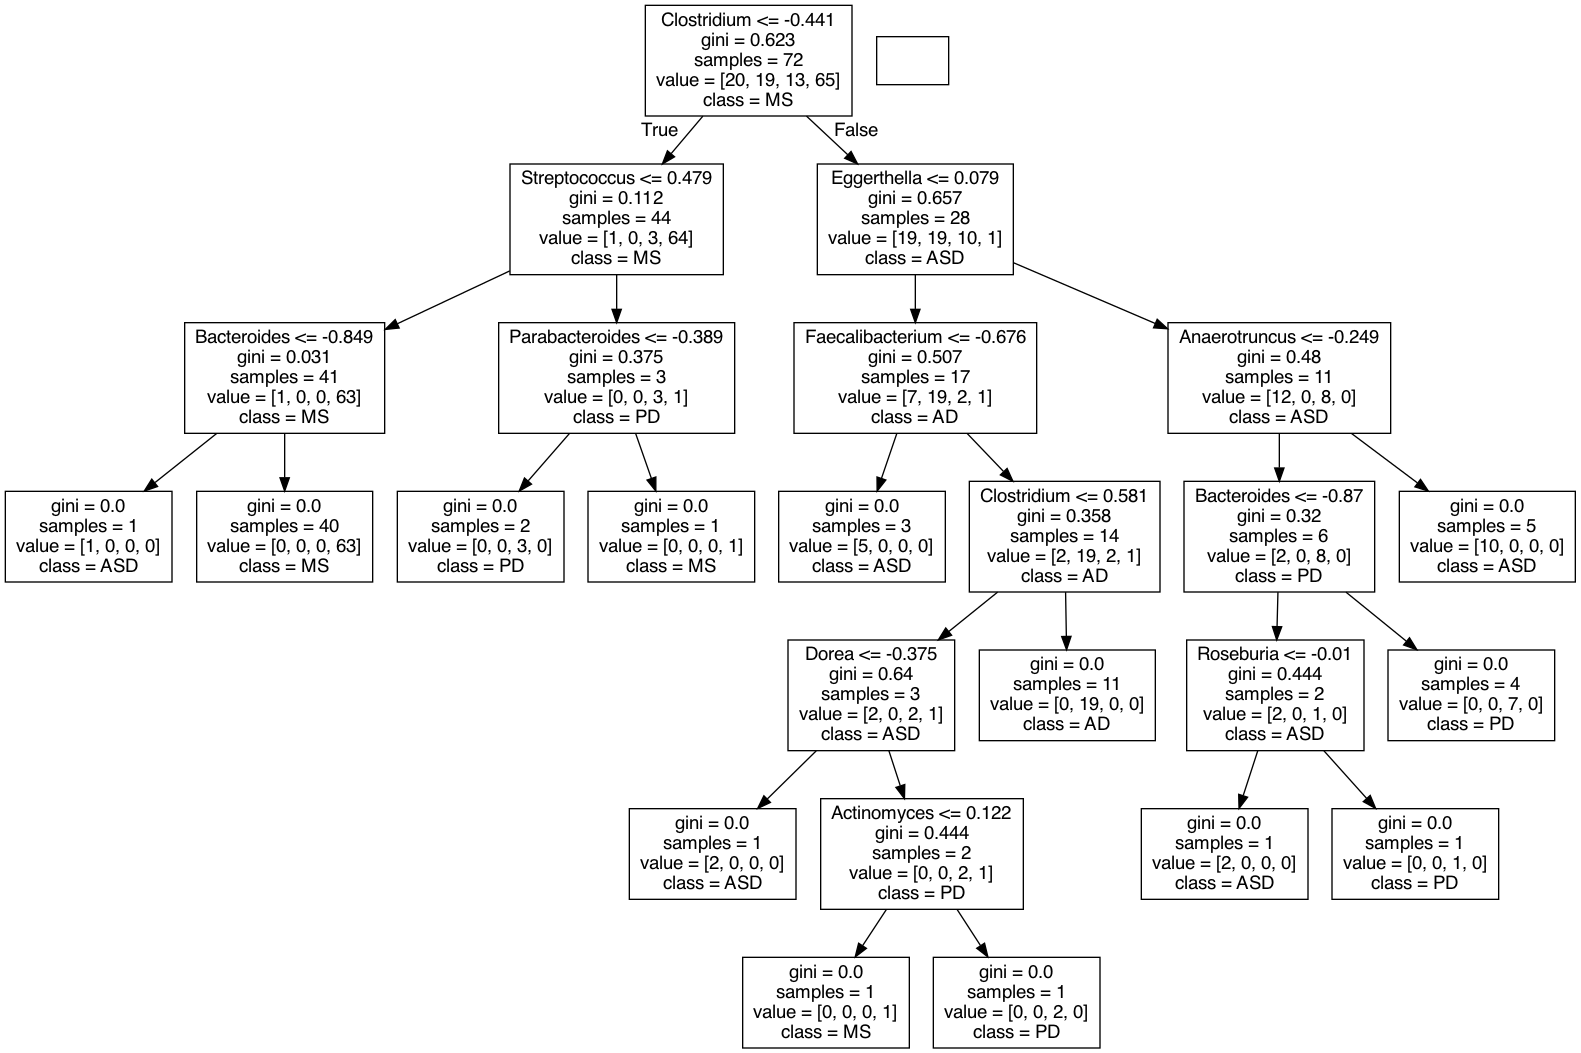

In [19]:
# followed this tutorial for getting image: https://naysan.ca/2019/11/26/visualize-a-decision-tree-with-sklearn/
# i just plotted one of the trees:
out_file = sk.tree.export_graphviz(out[0],label='all', feature_names=feat, class_names= ['ASD', 'AD', 'PD', 'MS'])

graph = pydotplus.graph_from_dot_data(out_file)
Image(graph.create_png())